# Table of Contents

1. [Introduction](#Introduction)
1. [Mathematical Model](#Model)
1. [Results](#Results)
1. [Discussion](#Discussion)
  1. [Discussion of Alternate Models](#Discussion-of-Alternative-Models-and-Approaches)
1. [Conclusion](#Conclusion)

# Introduction

After using Julia to solve the Hovercraft trajectory planning problem, we were interested in solving more complex motion planning problems relevant to robotics. The problem of interest involves navigating a 2D map of obstacles with the objectives of minimizing energy lost to acceleration. We will also discuss results from minimizing the distance objective. This optimization problem is applicable to robots with limited power supplies and autonomous vehicles specifically. 

Our problem at its root is a simplification of the Piano Mover’s problem.  In the Piano Mover’s problem, you are given a starting point, an ending point, a description of the moving vessel, and a description of the environment.  The goal is to find a path through the environment that avoids all obstacles and optimizes some objective function, such as distance traveled or time elapsed.[1]  In our variation, the vessel acts like a singular point attempting to move through a set of mathematically defined regions that the point cannot pass through. Additionally, our goal is to minimize the total energy lost.  Since our algorithm only tracks a point, this greatly simplifies the Piano Mover’s problem, which exists in the configuration space. The configuration space is related to state spaces in physics, which describe the robots “world” in a topological space of non-colliding points.[3] 

Path planning has countless applications in the modern world.  As we move further towards completely autonomous vehicles and automated corporate supply chains, it is necessary to optimize the amount of energy and time used in order to minimize operating costs. Self driving cars are currently in development and the principles can easily be applied from 2D kinematics to higher dimensional spaces, potentially enabling aviation and space flight. One industry application of 3D path planning we can expect to see in the near future will be delivery drones. Safe and efficient autonomous systems will heavily rely on robust path planning strategies.  

The feasible area of motion is bounded by flat or curved walls, which are represented by linear and nonlinear constraints respectively. The 2D maps were manually generated, with the goal of testing Julia’s performance in various obstacle settings. A few of the situations tested include a winding path, a narrow path obstructed with multiple objects, and a bending path of varying curvature. 


## General Description of Path Planning Problem

Our problem at its root is a simplification of the Piano Mover’s problem.  In the Piano Mover’s problem, you are given a starting point, an ending point, a description of the moving vessel, and a description of the environment.  The goal is to find a path through the environment that avoids all obstacles and optimizes some objective function, such as distance traveled or time elapsed.[1]  In our variation, the vessel acts like a singular point attempting to move through a set of mathematically defined regions that the point cannot pass through. Additionally, our goal is to minimize the total energy lost.  Since our algorithm only tracks a point, this greatly simplifies the Piano Mover’s problem, which exists in the configuration space. The configuration space is related to state spaces in physics, which describe the robots “world” in a topological space of non-colliding points.[3] 

## Applications of Path Planning

Path planning has nearly unlimited applications in the modern world.  As we move further towards completely autonomous vehicles and automated corporate supply chains, it will become necessary to optimize the amount of energy and time used in order to minimize operating costs.  Self driving cars are currently in development and the principles can easily be applied to 2D and higher dimensional spaces allowing for use in aviation and space flight as well as traditional kinematics.  Any future that uses autonomous vehicles will need robust path planning optimization.  

## Data Generation

This problem will explore robotic path planning as it relates to minimizing energy used. For example, a robot sent to mars may only have a finite battery life and want to travel from point A to point B while using as little power as possible. Along the way it will have to avoid obstacles and space in its environment that would cause extra power usage, such as hills. 

We will make the assumption that all energy usage comes from applied acceleration, both for controlling speed and heading of the robot. The result of this is that we will need to minimize all acceleration, not just thrust. We will need to take into account the value of acceleration in both x and y directions, though with less care about which direction they are in. In other words, we will not differentiate between acceleration due to speeding up and slowing the robot down. 

To combine the acceleration vectors, we will use the squared values in both x and y. In order to get total acceleration used, we will sum those values. This lends itself easily to a Ridge Regression model, where the objective value is the sum of squared values.

Representing acceleration as a 2D matrix $u_A$, our objective becomes:

$$ 
\begin{aligned}
\underset{x_A, v_A \in \mathbb{R^2}}{\text{minimize}}\qquad& \lVert u_A \rVert ^2
\end{aligned}
$$

Ridge regression, also known as Tikhonov or L_2 regression, is ideal for this model for a couple reasons. First off, summing the squared values has the effect of smoothing out the resulting objective value. This is ideal because we want a continuous transition between acceleration values at different timesteps to model the true motion of our robot. Additionally, solving for the problem will begin with initializing our acceleration matrix $u_A$ to empty values for each timestep, and then adjusting them appropriately to find an optimal path and acceleration profile. We will not use Lasso/L_1 becuase our model will not be sparse (having non-zero values for acceleration at all time steps) and we will not use L_infinity becuase we do not expect the acceleration values to be nearly equal for all time steps. 

As we will have the advantage of built-in smoothing through our objective function, we will attempt to solve our min-acceleration path planning problem in a continuous space. Discrete space has the advantage of being able to be represented by connected nodes in a graph, but we feel that using non-linear solvers we will be able to bretter describe the complex dynamics at play. Modeling in continuous space will allow for more accurate acceleration profiles of planned paths, but may result in solving difficulties. We will address these difficulties by using an approximate model of the kinematic relations. 


The model for this problem is based on projectile kinematics relating position, velocity, and acceleration. Most generally, the equations forming that relationship are:

$$ x_{t+1} = x_t + v_t\Delta{t} + \frac{1}{2}u_t\Delta{t}^2 $$
$$ v_{t+1} = v_t + u_t\Delta{t} $$

Where $u_t$ is a free variable that we will optimize for. 

On it's own, this model is nonlinear and could take a long time to solve as well as make it difficult to form constraints. To simplify our model while still giving us accurate approximations of the dynamic performance we will tune our model in the followign ways:

- We will stay in 2D space in order to remove a degree of freedom from our model and simplify geometric constraints, as well as make it easier to check results against our own intuition. 
- Time steps will be integer values to allow $\Delta{t}$ to be one. This allows us to remove effectively remove the quadratic relation between position and acceleration.
- Because acceleration will be half the value of velocity at all times in the position kinematic equation, we will remove the relation between acceleration and position for our model. This is an assumption that will make the the position slightly different from what it should be but will still give us good approximation to the true optimal path.
- We will apply a scaling factor to the velocity term in the kinematic equation for position in order to increase the resolution of our positions. This will allow the position to change only a small amount relative to velocity so we can get a more accurate path. It will make our velocity relatively large for the model, but the increased positional resolution will allow for better representation of the dynamics at play, and thus a more accurate acceleration profile.  

Thus our model is as follows:

$$ x_{t+1} = x_t + f v_t $$
$$ v_{t+1} = v_t + u_t $$

Where $f$ is our scaling factor. 

The variables in our model will then be position, $x_A$, velocity $v_A$, and accleration $u_A$. We can link all of these together in 2D space by parameterizing their associated $x$ and $y$ values by time. Thus our variables are:

$$ x_A = \begin{bmatrix} x_1 & x_2 & ... & x_{time} \\ 
                         y_1 & y_2 & ... &  y_{time} \end{bmatrix} $$
                    
$$ v_A = \begin{bmatrix} v_{x,1} & v_{x,1} & ... & v_{x,time} \\ 
                         v_{y,1} & v_{y,1} & ... & v_{y,time} \end{bmatrix} $$
                    
$$ u_A = \begin{bmatrix} u_{x,1} & u_{x,1} & ... & u_{x,time} \\ 
                         u_{y,1} & u_{y,1} & ... & u_{y,time} \end{bmatrix} $$

Where we will leave $u_A$ as our free variable that we will optimize. We can apply starting and ending constraints to $x_A$ and $v_A$ and times $1$ and $time$ to specify starting and ending conditions respectively. We can also limit the min and max values for $x_A$ and $v_A$ to make the model more realistic of true values as well as help our solver find optimal solutions. These max and min constraints are applied on a per-case basis and would not be included in the general problem. 

We will modeling obstacles as circles that our path needs to avoid. This constraint can be created by requiring that the euclidean distance from any point in our path is at least a circle's radius r from the circle center.

The robot center of mass will be represented by an orange dot along an optimal path shown in blue. $(x,y)$ will be a distance $R$ from a circle center $(C_x, C_y)$, where the circle's radius is $r$. A buffer relative to the circle's radius will be applied to model how the robot will have a body width extending from its center of mass.

The feasible area of motion is bounded by flat or curved walls, which are represented by linear and nonlinear constraints respectively. The 2D maps were manually generated, with the goal of testing Julia’s performance in various obstacle settings. A few of the situations tested include a winding path, a narrow path obstructed with multiple objects, and a bending path of varying curvature.

<img src="Pictures/circle_constraint.png" alt="Drawing" style="width: 400px;" /> 

Thus, the constraint is that 

$$ R \geq r + r/10 $$

To get R, we use the euclidean distance between the robot and circle center.

$$ R = \sqrt{(x-C_x)^2 + (y-C_y)^2} $$

So the constraint is,

$$ \sqrt{(x-C_x)^2 + (y-C_y)^2} \geq r + r/10 $$

However, to make it easier for our solver to converge we will avoid the square root operation by squaring both sides, thus making our constraint:

$$ (x-C_x)^2 + (y-C_y)^2 \geq (r + r/10)^2 $$

This constraint will be applied to all points $(x_t, y_t)$. This will make it so we only have to specify a single point for our path to stay away from, but at the same time will introduce a non-linearity due to the squared terms. We can address this complexity by using a solver capable of handling non-linear constraints, such as Ipopt. 

Our problem is 


$$
\begin{bmatrix} x_{t+1} \\ v_{t+1} \end{bmatrix}
\begin{bmatrix}
  1 & 2 \\
  3 & 4
\end{bmatrix} =_1
\begin{bmatrix} 5 \\ 6 \end{bmatrix}
$$

And here is an example of an optimization problem in standard form:

$$
\begin{aligned}
\underset{x \in \mathbb{R^n}}{\text{maximize}}\qquad& f_0(x) \\
\text{subject to:}\qquad& f_i(x) \le 0 && i=1,\dots,m\\
& h_j(x) = 0 && j=1,\dots,r
\end{aligned}
$$

# Results

## General Idea

<table><tr>
<td> Case A: <img src="Pictures/general_far.png" alt="Drawing" style="width: 400px;"/> </td>
<td> Case B: <img src="Pictures/general_close.png" alt="Drawing" style="width: 400px;"/> </td>
<td> Case C: <img src="Pictures/general_straight.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

The simplest version of our problem, one nonlinear obstacle obstructs a straight path from the specified start to finish.  As expected, the optimal trajectory will consist of one curve around the obstruction. In case B, the finish point is closer to the opposite side of the circle from the start position than in case A. The total acceleration is greater since the robot is required to make a sharper turn after it navigates around the circle, however both answers appear to be optimal.

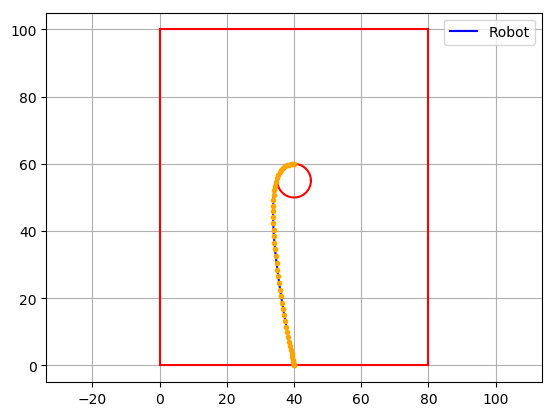

Optimal
Total Distance: 63.50808959912046
Total Acceleration: 2846.967864969774
Start: [40, 0]
End: [40, 60]


In [62]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50
start = [40, 0]
finish = [40, 60]
circles = [ 40 55;]

r = 5

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 80   )
@constraint(m, 0 .<= x_A[2, :] .<= 101  )

setvalue(x_A[:, 25], [20, 50])

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    @NLconstraint(m, (x_A[1,t]-circles[1,1])^2 + (x_A[2,t]-circles[1,2])^2  >= (r)^2) 
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

d_tot_actual = 0
for t in 1:time-1
    d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

# Calculate total acceleration used
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (getvalue(u_A[1,t+1])-getvalue(u_A[1,t]))^2 + (getvalue(u_A[2,t+1])-getvalue(u_A[2,t]))^2) 
end

println("Total Distance: ", d_tot_actual)

# Output
x_A = getvalue(x_A)
println("Total Acceleration: ", u_tot_actual)
println("Start: ", start)
println("End: ", finish)

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
plot( circles[1,1] .+ r*cos.(t), circles[1,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)

rightWally = range(0, stop=100, length = 100)
rightWallx = 0*rightWally
plot(rightWallx, rightWally, color="r")

leftWallx = 0*rightWally .+ 80
plot(leftWallx, rightWally, color="r")

bottomx = range(0, stop=80, length=10)
bottomy = 0*bottomx
plot(bottomx, bottomy, color="r")
topy = bottomy .+ 100
plot(bottomx, topy, color="r")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end



# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

# Varying Curvature

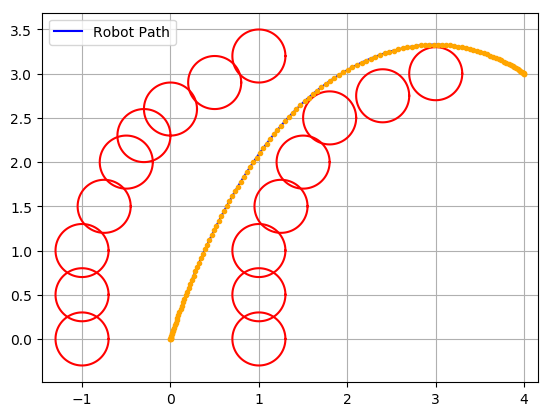

Optimal
Total Distance: 5.837324768445109
Total Acceleration: 40.49458030147541
Start: (0, 0)
Finish: (4, 3)


In [63]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 130 # time in minutes
start = [0, 0]
finish = [4, 3]

circles = [-1 0;
            -1 0.5;
            1 0;
            1 0.5;
            -1 1;
            1 1;
            1.25 1.5;
            -0.75 1.5;
            1.5 2;
            -0.5 2;
            0 2.6;
            3 3;
            1 3.2;
            2.4 2.75;
            1.8 2.5;
            0.5 2.9;
            -0.3 2.3]

r = 0.3 # radius of circles

num_circles, dim = size(circles)

# Variables
@variable(m, x_A[1:2, 1:time] >= 0 ) # Prevent from going backwards
@variable(m, v_A[1:2, 1:time]) # velocity
@variable(m, u_A[1:2, 1:time]) # acceleration

# Initial parameters
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot initially non-moving

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
    # distance between position and circle center must be greater than circle radius + buffer
    @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# Dynamic equations
factor = 1/3600
max_accel = 700
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + factor*v_A[:, t]) # Robot position 
    @NLconstraint(m, x_A[2, t+1] - x_A[2, t] <= r/1.2)
    @NLconstraint(m, x_A[1, t+1] - x_A[1, t] <= r/1.2)
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
    @constraint(m, -max_accel .<= u_A[:, t+1] .<= max_accel ) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # Regularization objective

# Solve
status = solve(m)
println(status)

# Calculate total distance traveled
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

# Calculate total acceleration used
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (getvalue(u_A[1,t+1])-getvalue(u_A[1,t]))^2 + (getvalue(u_A[2,t+1])-getvalue(u_A[2,t]))^2) 
end

# Output
x_A = getvalue(x_A)
println("Total Distance: ", d_tot_actual)
println("Total Acceleration: ", u_tot_actual)
println("Start: (", start[1],", ", start[2],")")
println("Finish: (", finish[1],", ", finish[2],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot Path")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

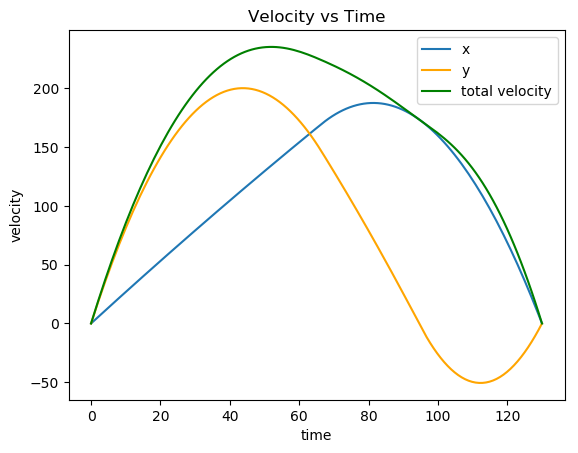

In [64]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x" )
plot(x[:], getvalue(v_A)[2,:], label="y" , color = "orange")
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:].^2)).^0.5
plot(x[:], total_v, label="total velocity" , color = "green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

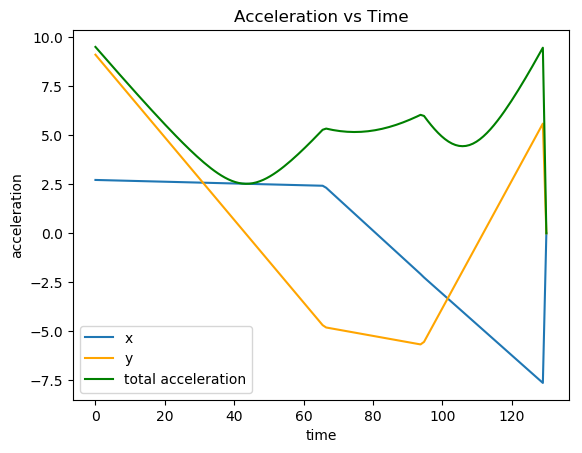

In [65]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y", color = "orange")
total_u = (getvalue(u_A[1,:]).^2 + getvalue(u_A[2,:].^2)).^0.5
plot(x[:], total_u, label="total acceleration" , color = "green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

# Narrow Obstructed Track

The narrow track combines linear and nonlinear constraints. A straight path is defined by two parallel vertical boundaries, and the path is partially obstructed by circle objects. 

Without specifying guess values using Julia’s setValue function, Ipopt selects a path that goes around all five of the obstacles. This conservative path does not appear to be the optimal path in terms of minimizing acceleration. Upon inspection, a better path would navigate through the obstacles. This is confirmed by specifying a guess value for the position at time tend/2. 

Nonlinear solvers such as Ipopt use Quasi-Newton methods to search for a local maximum of the objective function, starting from the guess values if they are specified. Since nonlinear solvers search for a local optimum instead of a global optimum, we cannot guarantee each solution path to be optimal. This example specifically solidified our understanding of the strategy of nonlinear solvers, and further proves that nonlinear solvers are incredibly sensitive to set guess values.


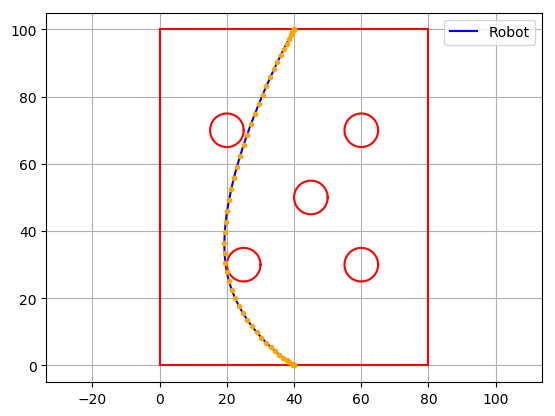

Optimal
Total Distance: 111.25770716769841
Total Acceleration: 2.407766469420638e7
Start: [40, 0]
End: [40, 100]


In [66]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50
start = [40, 0]
finish = [40, 100]
#time_step = 36
circles = [25 30;
            60 30;
            45 50;
            20 70;
            60 70;
            ]
r = 5

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 80   )
@constraint(m, 0 .<= x_A[2, :] .<= 101  )

setvalue(x_A[:, 25], [20, 50])

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
        @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

println("Total Distance: ", d_tot_actual)

# Output
x_A = getvalue(x_A)
println("Total Acceleration: ", getobjectivevalue(m))
println("Start: ", start)
println("End: ", finish)

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

rightWally = range(0, stop=100, length = 100)
rightWallx = 0*rightWally
plot(rightWallx, rightWally, color="r")

leftWallx = 0*rightWally .+ 80
plot(leftWallx, rightWally, color="r")

bottomx = range(0, stop=80, length=10)
bottomy = 0*bottomx
plot(bottomx, bottomy, color="r")
topy = bottomy .+ 100
plot(bottomx, topy, color="r")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

### Same model with using a guess value.

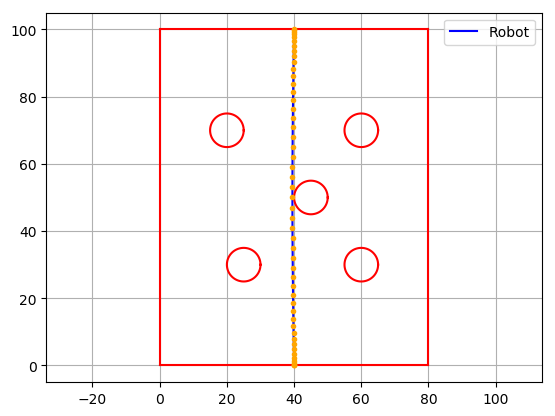

Optimal
Total Distance: 100.0063448200894
Total Acceleration: 1.3229772990574691e7
Start: [40, 0]
End: [40, 100]


In [67]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50
start = [40, 0]
finish = [40, 100]
circles = [25 30;
            60 30;
            45 50;
            20 70;
            60 70;
            ]

r = 5

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 80   )
@constraint(m, 0 .<= x_A[2, :] .<= 100  )

setvalue(x_A[:, 25], [40, 50])

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
        @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

println("Total Distance: ", d_tot_actual)

# Output
x_A = getvalue(x_A)
println("Total Acceleration: ", getobjectivevalue(m))
println("Start: ", start)
println("End: ", finish)

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

rightWally = range(0, stop=100, length = 100)
rightWallx = 0*rightWally
plot(rightWallx, rightWally, color="r")

leftWallx = 0*rightWally .+ 80
plot(leftWallx, rightWally, color="r")

bottomx = range(0, stop=80, length=10)
bottomy = 0*bottomx
plot(bottomx, bottomy, color="r")
topy = bottomy .+ 100
plot(bottomx, topy, color="r")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

# Macaroni

We wanted to make sure our model was valid for more complex tracks by making a curved track. To do so we idealized the track as a set of concentric circles, leveraging our geometric constraints so that the position was constrained outside each smaller circle and within a larger circle to define the bounds of the track. Because our circle constraint is independent of orientation of the position vector, we could maintain a similar set of constraints while making our track more complex. 

Ideally, assuming  appropriate x positions, the position of the robot is constrained by the first or third set of concentric circles when the robot is at a positive y position, while being constrained by the second set of concentric circles at a negative y position. Without the ability to accurately apply conditional constraints to the optimizing variables to achieve this, we approximated that about a third of the time step would be spent in each region and constraints were applied in such a way. The plot of the track and ths the circles are parameterized to make an aesthetically accurate depiction of a feasible track. However, the circular constraints are not parameterized, resulting in an area of overlapping constraints in transitioning regions. This allows a smooth transition in constraints between each set of constraining circles to allow for a feasible solution. While assuming each region is traversed in a third of the time step may not hold true to the actual optimal path, due to the overlapping regions, there is room for the solver to have leniency in optimizing the positions of the robot during transition of constraints to create a very accurate approximation of the optimal path of the robot.

Future variations of this can experiment with varying curvature by changing the radii of the constraining circles, starting and ending positions of the robot, boundary buffers, and different objective functions (such as minimizing distance). This model can be applied to idealize winding paths or to constraing paths through a defined areaby using a variety of constraining circles of varying sizes with inclusive or exclusive constraints. The results of the model provide very importaant information on the relationship and thus cost of minimizing distance while considering a minimal acceleration. Because the model combines many different constraints, the results can be used in applications where the cost of energy is very high.

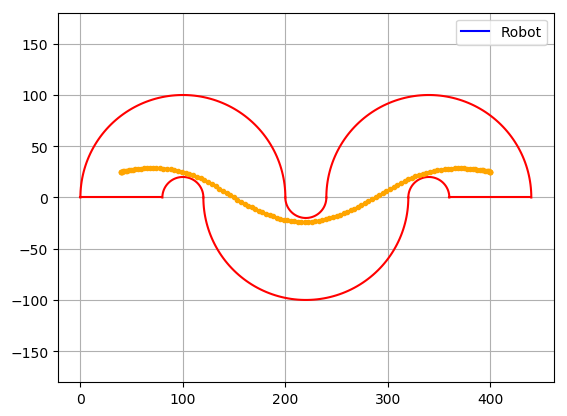

Optimal
Total Distance: 155.45680760103883
Total Acceleration: 3.0841633509932607e7
Start: [40, 25]
End: [400, 25]


In [68]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

ti = 120
start = [40, 25]
finish = [400, 25]
circles = [100 0;
            100 0;
            ]
circles_U = [ 220 0;
            220 0;]
circles2 = [340 0;
            340 0;]
r = [20,100]

num_circles, dim = size(circles)
tstep = floor(Int, ti/3)

@variable(m, x_A[1:2, 1:ti])
@variable(m, v_A[1:2, 1:ti])
@variable(m, u_A[1:2, 1:ti])

# x index, y index
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 440  )
@constraint(m, -100 .<= x_A[2, :] .<= 100  )

# Keep path away from obstacles defined by radii from circle center
for t in 1:tstep
        @NLconstraint(m, (x_A[1,t]-circles[1,1])^2 + (x_A[2,t]-circles[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles[2,1])^2 + (x_A[2,t]-circles[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

for t in (2*tstep):ti
        @NLconstraint(m, (x_A[1,t]-circles2[1,1])^2 + (x_A[2,t]-circles2[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles2[2,1])^2 + (x_A[2,t]-circles2[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

for t in tstep:(2*tstep)
        @NLconstraint(m, (x_A[1,t]-circles_U[1,1])^2 + (x_A[2,t]-circles_U[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles_U[2,1])^2 + (x_A[2,t]-circles_U[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] <= 0)
end
# Dynamic equations
for t in 1:ti-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, ti] .== finish) # final location
@constraint(m, v_A[:, ti] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Output
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

println("Total Distance: ", d_tot_actual)

x_A = getvalue(x_A)
println("Total Acceleration: ", getobjectivevalue(m))

println("Start: ", start)
println("End: ", finish)

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")
t = range(0,stop=pi,length=100)   

for c in 1:num_circles
    plot( circles[c,1] .+ r[c]*cos.(t), circles[c,2] .+ r[c]*sin.(t), color="r") 
    plot( circles2[c,1] .+ r[c]*cos.(t), circles2[c,2] .+ r[c]*sin.(t), color="r")
    plot( circles_U[c,1] .- r[c]*cos.(t), (circles_U[c,2] .+ r[c]*sin.(t)).*-1, color="r")
end

botWallLX = range(0, stop=80, length = 10)
botWallLY = 0*botWallLX
plot(botWallLX, botWallLY, color="r")

botWallRX = range(360, stop=440, length = 10)
botWallRY = 0*botWallRX
plot(botWallRX, botWallRY, color="r")

plot(start[1], start[2], ".", color="orange")
plot(finish[1], finish[2], ".", color="orange")

# Plot time steps
for t in 1:ti
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;


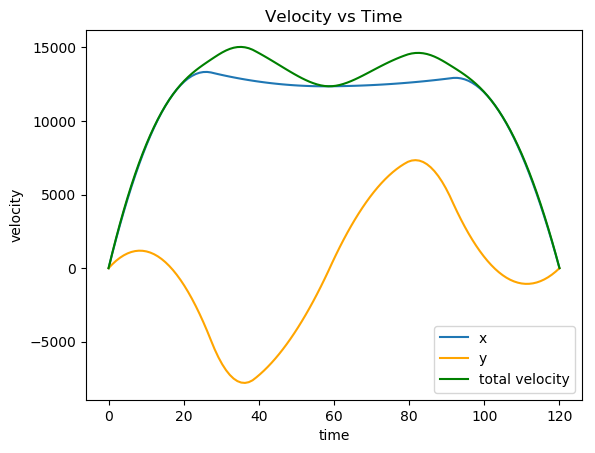

In [69]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(v_A)[1,:], label="x", )
plot(x[:], getvalue(v_A)[2,:], label="y", color="orange" )
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;


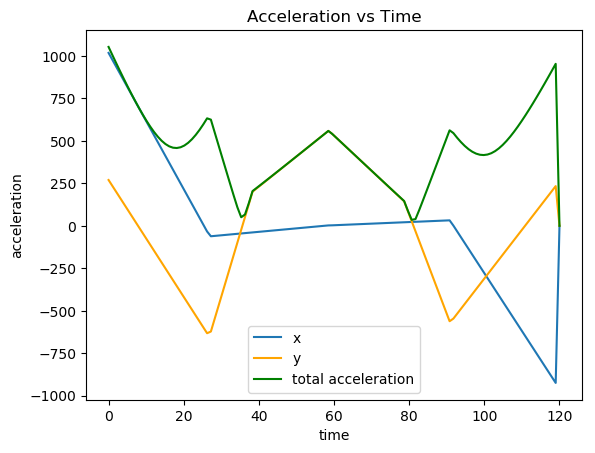

In [70]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y", color="orange")
total_v = (getvalue(u_A[1,:]).^2 + getvalue(u_A[2,:]).^2).^0.5
plot(x, total_v, label="total acceleration", color="green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

We wanted to test another case of our track with a different division of time step for each region to display differences in optimal solution. In this example, we set both time steps for the first and third regions to be more than a third and the second time step to be the remaining time. The resulting distance of the track is shorter by around 9% of the original distance but the total energy required to traverse the path increased by around 130% of the original. In situations where minimizing distance is required while keeping energy low, this may be a more ideal situation, but for any situation considering the cost of energy, this tradeoff is not ideal.

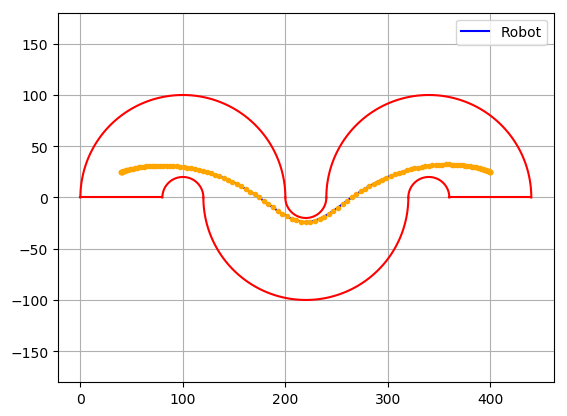

Optimal
Total Distance: 141.62198069169997
Total Acceleration: 7.081376575255921e7
Start: [40, 25]
End: [400, 25]


In [71]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

ti = 120
start = [40, 25]
finish = [400, 25]
circles = [100 0;
            100 0;
            ]
circles_U = [ 220 0;
            220 0;]
circles2 = [340 0;
            340 0;]
r = [20,100]

num_circles, dim = size(circles)
tstep = floor(Int, ti/3)

@variable(m, x_A[1:2, 1:ti])
@variable(m, v_A[1:2, 1:ti])
@variable(m, u_A[1:2, 1:ti])

# x index, y index
@constraint(m, x_A[:, 1] .== start) # Robot's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 440  )
@constraint(m, -100 .<= x_A[2, :] .<= 100  )

# Keep path away from obstacles defined by radii from circle center
for t in 1:50
        @NLconstraint(m, (x_A[1,t]-circles[1,1])^2 + (x_A[2,t]-circles[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles[2,1])^2 + (x_A[2,t]-circles[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

for t in 50:70
        @NLconstraint(m, (x_A[1,t]-circles_U[1,1])^2 + (x_A[2,t]-circles_U[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles_U[2,1])^2 + (x_A[2,t]-circles_U[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] <= 0)
end

for t in 70:120
        @NLconstraint(m, (x_A[1,t]-circles2[1,1])^2 + (x_A[2,t]-circles2[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles2[2,1])^2 + (x_A[2,t]-circles2[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

# Dynamic equations
for t in 1:ti-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, ti] .== finish) # final location
@constraint(m, v_A[:, ti] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Output
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

println("Total Distance: ", d_tot_actual)

x_A = getvalue(x_A)
println("Total Acceleration: ", getobjectivevalue(m))

println("Start: ", start)
println("End: ", finish)

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")
t = range(0,stop=pi,length=100)   

for c in 1:num_circles
    plot( circles[c,1] .+ r[c]*cos.(t), circles[c,2] .+ r[c]*sin.(t), color="r") 
    plot( circles2[c,1] .+ r[c]*cos.(t), circles2[c,2] .+ r[c]*sin.(t), color="r")
    plot( circles_U[c,1] .- r[c]*cos.(t), (circles_U[c,2] .+ r[c]*sin.(t)).*-1, color="r")
end

botWallLX = range(0, stop=80, length = 10)
botWallLY = 0*botWallLX
plot(botWallLX, botWallLY, color="r")

botWallRX = range(360, stop=440, length = 10)
botWallRY = 0*botWallRX
plot(botWallRX, botWallRY, color="r")

plot(start[1], start[2], ".", color="orange")
plot(finish[1], finish[2], ".", color="orange")

# Plot time steps
for t in 1:ti
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

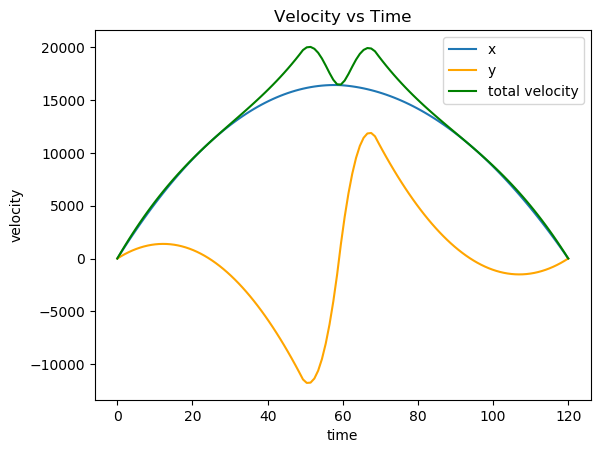

In [72]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(v_A)[1,:], label="x", )
plot(x[:], getvalue(v_A)[2,:], label="y", color="orange" )
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

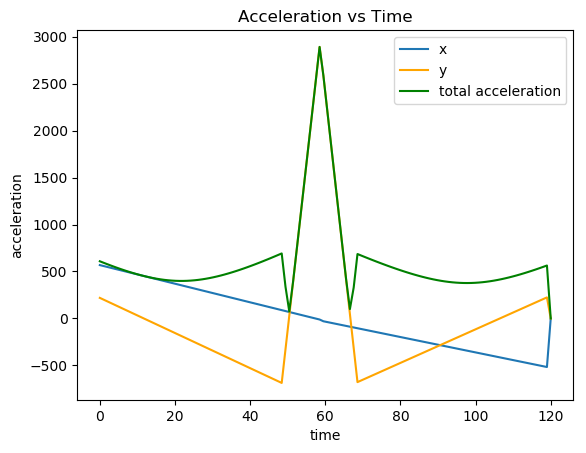

In [73]:
x = range(0, stop=ti, length=ti)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y", color="orange")
total_v = (getvalue(u_A[1,:]).^2 + getvalue(u_A[2,:]).^2).^0.5
plot(x, total_v, label="total acceleration", color="green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

# Discussion

### Segment crossing detection

Once constraints were made avoiding obstacles represented by circles ways of avoiding more complex geometries were explored. One proposed solution was to detect whether a line segment was crossed or not by the path, and make a constraint to prevent that from happening. With this technique, geometries of any shape could be represented by a set of segments where the path would be constrained from crossing any of the segments in that set. 

Segment crossing was detected by analyzing all four of the points involved: the two end points of one segment and the two end points of the other. 

--> orientation

--> collinear check

Functions were made for these checks and the code for them is included above the graph.

To implement this detection as a way of affecting the path, conditional constraints could be used where a binary variable would be set to equal one if the combination of x_A[:,t] and x_A[:,t+1] would cross a known segment. The values of x_A[:,t] and x_A[:,t+1] would then be saved so they could be used in a second constraint. The second constraint would be that if x_A[:,t] was equal to that saved variable, that then x_A[:,t+1] could not be equal to it's associated saved variable. The constraints could be written as the following:

--> constraint one to set x1[t] = x_A[:,t] and x2[t] = x_A[:,t+1]

--> constraint preventing combination

While this solution was proposed, it could not be evaluated with the existing model without using and MINLP solver such as NLopt with a specified algorithm or KNITRO. Future work could be done to implement this solution. 

Code below shows how the detection works. Start/finish values for both the path and segment can be changed, as well as the circle location and size.

In [74]:
function point_on_segment(a, b, c)
    # a and b end points of a segment, c point to check
    # only gets called if c is determined by orientation(a,b,c) to be collinear with ab
    # returns true if c on segment ab, false otherwise 
    if ( min(a[1], b[1]) <= c[1] && c[1] <= max(a[2], b[2]) )
        if ( min(a[2], b[2]) <= c[2] && c[2] <= max(a[2], b[2]) )
        return true
        end
    end
    return false
end
;

In [75]:
function orientation(a, b, c)
    # a and b end points of a segment, c point to check
    
    #slope1 = (b[2]-a[2])/(b[1]-a[1])
    #slope2 = (c[2]-b[2])/(c[1]-b[1])
    #val = slope1 - slope2
    
    val = (b[2]-a[2])*(c[1]-b[1]) - (c[2]-b[2])*(b[1]-a[1])
    if(val<0)
        return 1 # clockwise
    end
    if(val>0)
        return 2 # counterclockwise 
    end
    return 0 # slopes the same
    
end
;

In [76]:
function intersection(a, b, c, d)
    # a and b existing segment, c and d segment to check
    # returns true if intersection discovered, false otherwise
    
    # ab vs new segment test
    ab_vs_c = orientation(a,b,c)
    ab_vs_d = orientation(a,b,d)
    
    # new segment vs ab test
    cd_vs_a = orientation(c,d,a)
    cd_vs_b = orientation(c,d,b)
    
    # if both orientation tests are different, then segments cross 
    if(ab_vs_c != ab_vs_d && cd_vs_a != cd_vs_b)
        return true
    end
    
    # verify any collinearity does not result in crossing
    
    # c collinear with ab
    if(ab_vs_c == 0 && point_on_segment(a,b,c))
        return true
    end
    
    # d collinear with ab
    if(ab_vs_d == 0 && point_on_segment(a,b,d))
        return true
    end
    
    # a collinear with cd
    if(cd_vs_a == 0 && point_on_segment(c,d,a))
        return true
    end
    
    # b collinear with cd
    if(cd_vs_b == 0 && point_on_segment(c,d,b))
        return true
    end
    
    # if crossing not detected, return false
    return false   
    
end
;

Optimal


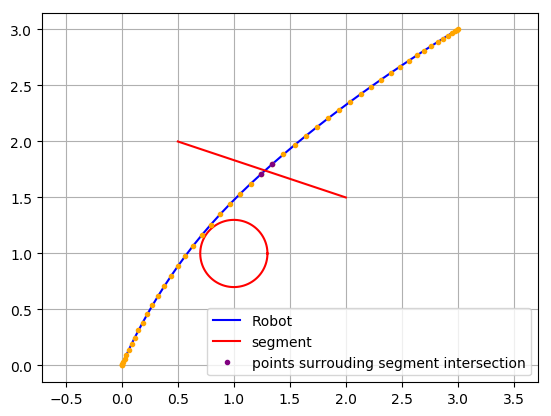

Total Distance: 4.313687820018561
Total Acceleration: 129.78590014272254
Start: (0, 0)
Finish: (3, 3)
Crossed segment between time 26 and 27


In [77]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50                 # simulation time

#############################################################

start = [0, 0]            # starting location
finish = [3, 3]           # ending location

segment_end2 = [0.5 2]    # x and y coordinates for segment left/top 
segment_end1 = [2 1.5]    # x and y coordinates for segment right/bottom

circles = [1 1]           # x and y coordinate of circle center

r = 0.3                   # radius of circles
#############################################################

segment = [segment_end1[1] segment_end2[1];  
         segment_end1[2] segment_end2[2]]

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# Initial constraints
@constraint(m, x_A[:, 1] .== start) # Robot initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot initial velocity 

# Keep path away from line segments
# TODO: incorporate conditional constraints to prevent x_A from crossing segment
# a = [segment[1],segment[2]]
# b = [segment[3],segment[4]]
# for t in 1:time-1
#     c = [x_A[1,t], x_A[2,t]]
#     d = [x_A[1,t+1], x_A[2,t+1]]
#     if (intersection(a,b,c,d))
#        println("cross") 
#     end
# end

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
    # distance between position and circle center must be greater than circle radius + buffer
    @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Robot position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Get values of path
x_A = getvalue(x_A)
u_A = getvalue(u_A)


# True total distance traveled
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2 )
end

# True total acceleration
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (u_A[1,t+1]-u_A[1,t])^2 + (u_A[2,t+1]-u_A[2,t])^2) 
end


# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot segment
plot(segment[1,:], segment[2,:], color="red", label="segment")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Detect if path crosses segment or not
a = [segment[1],segment[2]]
b = [segment[3],segment[4]]
first_cross = 0
last_cross = 0
for t in 1:time-1
    c = [x_A[1,t], x_A[2,t]]
    d = [x_A[1,t+1], x_A[2,t+1]]
    if intersection(a,b,c,d) 
        first_cross = t
        last_cross = t+1
    end
end

# Output
println("Total Distance: ", d_tot_actual)
println("Total Acceleration: ", u_tot_actual)
println("Start: (", start[1],", ", start[2],")")
println("Finish: (", finish[1],", ", finish[2],")")

# Plot points surrounding section of path crossing segment
if first_cross > 0
    plot(x_A[1, first_cross:last_cross], x_A[2, first_cross:last_cross], ".", color="purple", label="points surrouding segment intersection")
    println("Crossed segment between time ",first_cross," and ", last_cross)
else
    println("Path does not cross segment")
end

# Formatting
axis("equal")           # make x and y scales equal
grid("on")
legend()
;

### Modeling topography optimization

Another way to build on the existing model would be to include external forcing factors. An example of this could be to imagine trying to find an optimal path through a region containing hills and valleys while still avoiding any obstacles along the way. To simplify this model, a 2D planar approach is used where hills are modeled as "sand pits" where an extra amount of accleration would need to be added to keep the vehicle moving. 

This could be accomplished by using conditional constraints

--> put conditional constraints here

 $$ \text{or} \ P(A=1)*P(B=5, C=1) = \frac{1}{6} * \frac{1}{6} * \frac{1}{6} = \frac{1}{216}$$



Introducing these constraints requires using a binary variable z which equals one for any timesteps that would have the path travel through the sand pit, and equals zero otherwise. However, adding the mixed integer variable turns the problem from an NLP into an MINLP. A solver was not found (yet) that worked with all constraints specified. To help test the concept of using conditional constraints in this way, z values for a specific time interval were set to one and then used to affect the acceleration.

When the z values are equal to one, meaning the path would cross through the sand pit (shown by the green circle),

--> z = 1, solve conditional constraint

This causes the acceleration to increase, as can be seen in how the path changes from linear to an s-curve and the total acceleration goes up compared to the case where the acceleration is not affected. The affected acceleration can also be seen in the velocity and acceleration graphs. The velocity drops throughout the sand pit section and the acceleration adjusts to get the robot moving fast at first so it can coast with minimal acceleration before then applying more acceleration to get out of the costly sand pit section sooner. 

<table><tr>
<td> <img src="Pictures/sandPit_on.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="Pictures/sandPit_on_velocity.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="Pictures/sandPit_on_accel.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

When the z values equal zero, the acceleration would be unconstrained so it could take on any value. 

--> z = 0, solve conditional cosntraint

The acceleration would then assume a typical linear strategy, as is shown by how the path goes straight through the sand pit. 

<table><tr>
<td> <img src="Pictures/sandPit_off.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="Pictures/sandPit_off_velocity.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="Pictures/sandPit_off_accel.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

Optimal


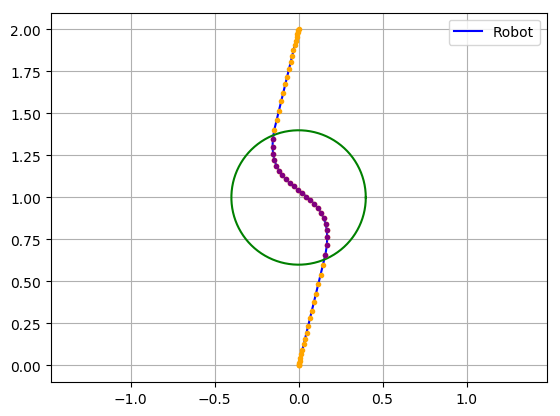

Total Distance: 2.1561247386456217
Total Acceleration: 181.5545328717028
Start: (0, 0)
Finish: (0, 2)


In [78]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 60           # simulation time
start = [0, 0]      # starting location
finish = [0, 2]     # ending location

sand = [0 1]        # Center of circle representing sand
r_sand = 0.4        # Radius of circle representing sand

num_sand, dim = size(sand)


# Variables
@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time]) 
#@variable(m, z[1:time], Bin) # create binary variable for z[t]=1 when path through sand, z[t]=zero otherwise

@constraint(m, x_A[:, 1] .== start) # Robot initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Robot initial velocity 

# Conditional constraint for z=1 when going through sand, need different solver (or algorithm for NLopt solver)
# m_lower = r_sand^2
# epsilon = 0.001
# for t in 1:time
#     for c in 1:num_sand
#     @NLconstraint(m, r_sand^2 - ((x_A[1,t]-sand[c,1])^2 + (x_A[2,t]-sand[c,2])^2 )  >= m_lower*z[t] + epsilon*(1-z[t])) 
#     end
# end

# Set parameters for conditional constraint applying external force on motion
F_drag = 20
mass = 10
m_sand = -10000000
z = zeros(time)

#############################################################
# Set z[i]=1 for specified time steps

start_sand = 20      # starting time step
end_sand = 42        # ending time step

for i in start_sand:end_sand
    z[i] = 1
end
#############################################################

#############################################################
# Comment/uncomment the below out to turn off/on the sand pit

for t in 1:time-1
    # if z[t] = 1, then apply external force to increase amount of acceleration needed
    @constraint(m, u_A[:,t+1] - ((u_A[:,t] + F_drag/mass)) .>= m_sand*(1-z[t+1]) )
end
#############################################################

# Dynamic equations
factor = 1/3600
for t in 1:time-1    
     @constraint(m, x_A[:, t+1] .== x_A[:, t] + factor*v_A[:, t]) # Robot position    
     @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Robot velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# True total distance traveled
d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

# True total acceleration
u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (getvalue(u_A[1,t+1])-getvalue(u_A[1,t]))^2 + (getvalue(u_A[2,t+1])-getvalue(u_A[2,t]))^2) 
end

# Output
x_A = getvalue(x_A)
println("Total Distance: ", d_tot_actual)
println("Total Acceleration: ", u_tot_actual)
println("Start: (", start[1],", ", start[2],")")
println("Finish: (", finish[1],", ", finish[2],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Robot")

# Plot sand
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_sand
    plot( sand[c,1] .+ r_sand*cos.(t), sand[c,2] .+ r_sand*sin.(t), color="green")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Plot points with applied force
for t in start_sand:end_sand
    plot(x_A[1, t], x_A[2, t], ".", color="purple")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

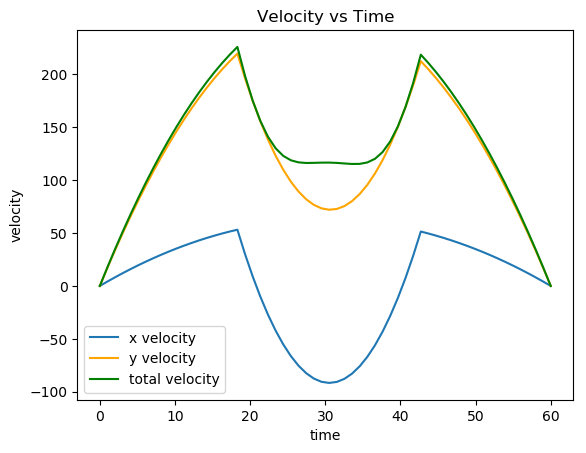

In [79]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x velocity")
plot(x[:], getvalue(v_A)[2,:], label="y velocity", color = "orange")
total_v = (getvalue(v_A[1,:]).^2 + getvalue(v_A[2,:]).^2).^0.5
plot(x, total_v, label="total velocity", color="green")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

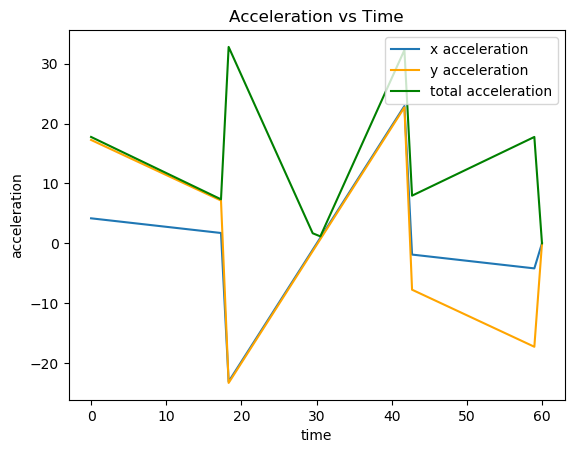

In [80]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x acceleration")
plot(x[:], getvalue(u_A)[2,:], label="y acceleration", color = "orange" )
total_u = (getvalue(u_A[1,:]).^2 + getvalue(u_A[2,:]).^2).^0.5
plot(x, total_u, label="total acceleration", color="green")
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

# Discussion of Alternative Models and Approaches

Simplifying the problem of interest to a graph traversal problem would likely increase the solver’s accuracy and performance. Graph traversal problems can be solved using linear solvers, which tend to have a more consistent performance compared to non-linear solvers such as Ipopt. The free space can be discretized in many ways, such as representing the map as a binary maze. By overlaying a grid of a specified resolution, mapping obstacles and infeasible regions as 0s and valid robot positions with 1s, a binary version of the map can be constructed. If any position within a cell is invalid, a 0 is assigned to that cell.  A valid path is a sequence of line segments between grid positions which are completely contained within the feasible regions of the map. Information pertaining to the robot’s velocity and acceleration would be impossible to estimate from this model, but it is possible to define the total distance function as the sum of the path segment lengths. 

A more accurate equivalent model might include cell decomposition. We will explore the tradeoffs between approximate and exact cell decomposition, as well the Voronoi diagram and visibility graph approaches. The mentioned approaches each discretize the free space and are solved by applying search algorithms such as A* or Dijkstra's algorithm to the resulting graphs. 


## Cell Decomposition

The general idea of this approach is subdividing the feasible space into regions called cells, and constructing a graph of nodes based on the resulting cell geometry. 

<img src = "Pictures/cellDecomp2.jpg" alt="Cellular Decompositon of the Space" width="500" height="333">

Figure 1. An example of quadtree cell decomposition, an approximate decomposition approach.

<img src = "Pictures/cellDecomp1.jpg" alt="Trapezoidal Decomposition of the Space" width="500" height="333">

Figure 2. Trapezoidal (exact) decomposition approach. From the original world (a), we decompose the free space into cells pictured in (b). (c) corresponds to the connectivity graph which will be searched for a valid path.

Answers obtained from cell decomposition approaches are dependent upon the minimum cell resolution. For this reason a valid path might not be found, even if one exists. The naive cell decomposition approaches have no clear notion of optimality, as shown in Figure 2 (e). If we were to use a sufficiently small grid resolution and applied a greedy search algorithm such as A* or Dijkstra's, it is possible to minimize the distance from the specified start and end positions.[3] 

## Voronoi Decomposition

By using a Voronoi diagrams to model our environment, we can find a route that completely avoids infeasible areas.  A Voronoi diagram decomposes the free space into cells, where each cell represents the subset of points who are closest to that cell’s given vertex.[1] Voronoi diagrams can be generated using the JuliaGeometry package.

If the start and end points exist in the feasible area of the environment, and there is a possible path from each point to a voronoi edge, we will be able to construct a path given the Voronoi graph is connected.[3] While the Voronoi approach will find a path if one exists, it is not effective in minimizing any kind of objective function. By avoiding obstacles as much as possible, resulting paths are often far too conservative.[1] Given this, it was not a very useful approach for our specific application. If a robot has unlimited time and resources and the only goal was to complete the route without crossing the boundaries, the Voronoi would find the “safest” solution since the voronoi edges are defined to be the maximum distance away from each boundary vertex. 

<img src = "Pictures/voronoi.jpg" alt="Voronoi Decomposition Example" width="500" height="333">

Figure 3. Voronoi Approach

## Visibility Approach

Perhaps the most applicable of the approaches we will discuss, the visibility approach, follows a roadmapping approach similar to Voronoi diagrams but defines valid road in a less conservative way. The visibility graph method was one of the earliest path planning methods discovered; it was originally researched by NJ Nilsson in 1969 [4]. 

Roads are defined by all line segments that can connect a vertex of one obstacle to a vertex of a different obstacle without crossing into the infeasible region. By making the assumption that our robot can be coincident with a boundary vertex, this greatly simplifies our model. An optimal implementation of this approach using Dijkstra’s or A* to find the shortest path is O(N^2)[3] where N corresponds to the number of boundary vertices.  

<img src = "Pictures/roadmap1.jpg" alt="roadmap jpeg" width="500" height="333">

Figure 4. Visibility graph

The most significant weakness in the visibility graph approach is that it stays as close to the boundaries as possible. It is possible that the shortest path generated for a map of sparse obstacles is worse than the generated path using the Voronoi approach. Provided more time, we would be interested in solving the minimum distance objective using the visibility and Voronoi approaches and further investigating the main advantages and disadvantage of each strategy.

# Conclusion

# Works Cited

[1] Burgard, Wolfram, et al. Introduction to Mobile Robotics: Robot Motion Planning. University of Freiburg, 2011, ais.informatik.uni-freiburg.de/teaching/ss11/robotics/slides/18-robot-motion-planning.pdf

[2] Pa, Weilyn. “Motion Planning in Robotics.” Robotics: Motion Planning, cs.stanford.edu/people/eroberts/courses/soco/projects/1998-99/robotics/basicmotion.html.

[3] “Robot Motion Planning.” Robot Motion Planning, CMU, www.cs.cmu.edu/afs/andrew/course/15/381-f08/www/lectures/motionplanning.pdf.

[4] Donald, Bruce, et al. Kinodynamic Motion Planning. Duke University, 1993, users.cs.duke.edu/~brd/papers/src-papers/jacm93.pdf.

[5] Janson, Lucas, et al. Monte Carlo Motion Planning for Robot Trajectory Optimization Under Uncertainty. Stanford University, web.stanford.edu/~pavone/papers/JSP.ISRR15.pdf.